# Data Generation for Car Loan Use Case
This notebook reports the steps to generate data folowing custom trends, applied on the Car Loan use case. There are three main parts:
* The first part is to generate data that folows a custom trend in general, including the possibility to specify what % a particular in-/decrease should be.
* The second part is to apply these tools on the Car Loan use case and to generate custom data for all Car Loan widgets.
* The third part is to ingest the data into Lily. The data is visualized in this local environment to have quicker feedback on code changes, but of course has to be ingested into Lily eventually.

# 0. Visualization Tools

These are some preparation tools just for the sake of visualization in this notebook. Basically, we can now aggregate and visualize data, grouped in databins. This part can be skipped.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d

In [2]:
databins = ['2016-01-01', '2016-01-15', '2016-02-01', '2016-02-15', '2016-03-01', '2016-03-15',
            '2016-04-01', '2016-04-15', '2016-05-01', '2016-05-15', '2016-06-01', '2016-06-15',
            '2016-07-01', '2016-07-15', '2016-08-01', '2016-08-15', '2016-09-01', '2016-09-15',
            '2016-10-01', '2016-10-15', '2016-11-01', '2016-11-15', '2016-12-01']
databinsZ = ['2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
            '2016-01-01', '2017-01-01']
databinsF = ['2016-11-30', '2017-11-30', '2018-11-30', '2019-11-30', '2020-11-30', '2021-11-30',
            '2022-11-30', '2023-11-30']
ticks = ('1/16', '2/16', '3/16', '4/16', '5/16', '6/16', '7/16', '8/16', '9/16', '10/16', '11/16', '12/16')

In [3]:
def createBins(df, databins, column='START', cumulative=True):
    if cumulative:
        return np.array([len(df[df.loc[:,column] < databins[i]]) for i in range(len(databins)-1)], dtype=float)
    return np.array([len(df[(df.END > databins[i]) & (df.END < databins[i+1])]) for i in range(len(databins)-1)])

# 1. Data Generation Tools
This part is about generating data that folows a custom trend in general. When the needed trend is constant, or increasing or decreasing in a consistent manner, this can be solved quite easily. When a more complex trend is needed, however, it is convenient to provide a function that accounts for any particularities in that trend.

### 1.1 Create Functions
These are four arbitrary functions for the sake of demonstration, visualized below.

In [4]:
# FUNCTION 1
def logit(x, position = 0.5, spread = -20, setoff = 0, altitude = 1):
    return (1/(1+np.exp(spread * (x - position)))) * altitude + setoff

# FUNCTION 2
def gauss(x, position = 0.5, deviation = 0.1, height = 0, altitude = 1):
    return (np.exp(-np.power(x - position, 2.) / (2 * np.power(deviation, 2.))) + height) * altitude

# FUNCTION 3
def winner(x):
    xPoints = np.linspace(0, 1, 5)
    yPoints = [1, 0, 0.5, 0, 1]
    h = interp1d(xPoints, yPoints)
    return h(x)

# FUNCTION 4
def peak(x):
    xPoints = (np.array([-6*365, 0, 1, 150, 180, 210, 365]) + 6*365) / (7*365.)
    yPoints = np.array([0, 2, 2, 2, 50, 2, 2]) / 50.
    i = interp1d(xPoints, yPoints)
    return i(x)

functions = [logit, gauss, winner, peak]

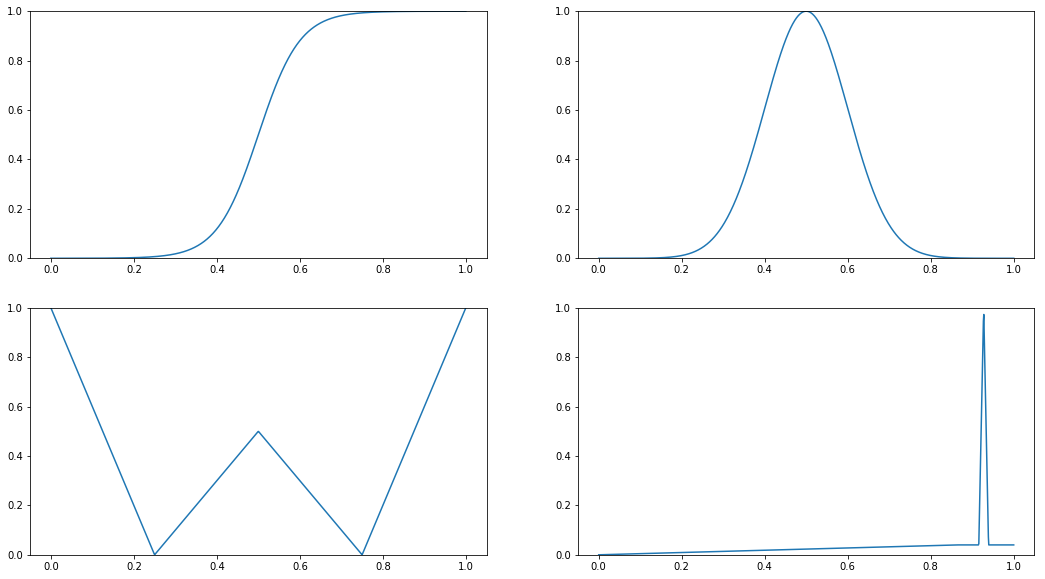

In [5]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i)
    ax.plot(x, f(x))
    plt.ylim(0,1)
plt.show()

### 1.2 Create Distributions

Here, 10000 random numbers are generated for every function. When plotted in a histogram, their distributions clearly folow the respective functions. The take-away message here is that any trend should be describable.

In [6]:
def generateDistribution(function, size=1):
    if size==1:
        x = np.random.rand()
        y = function(x)
        if np.random.rand() <= y:
            return x
        return generateDistribution(function)
    else:
        return np.array([generateDistribution(function) for _ in range(size)])

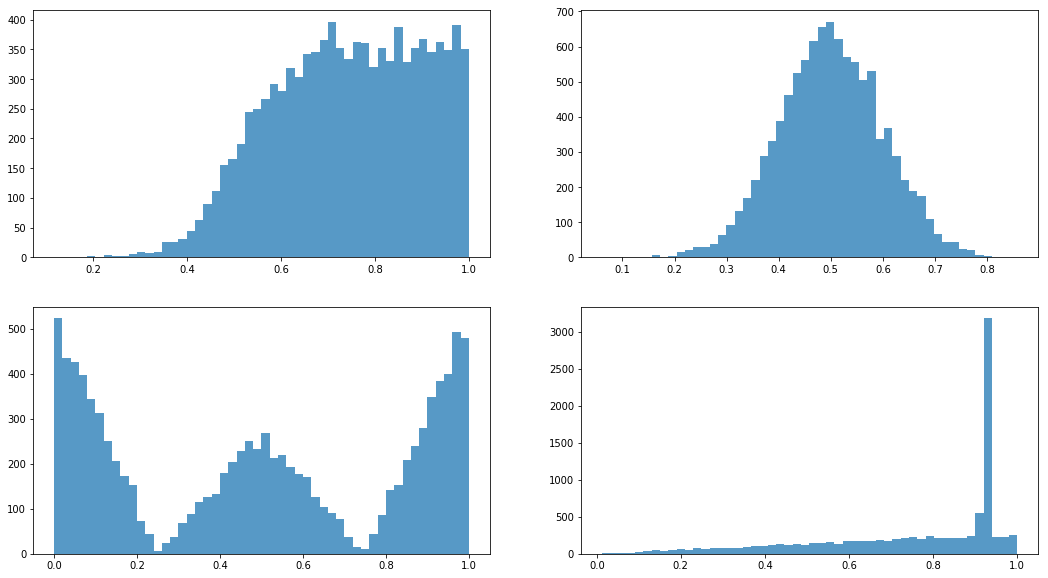

In [7]:
fig, axs = plt.subplots(2,2, figsize=(18, 10))
for i, (f, ax) in enumerate(zip(functions, axs.flatten())):
    picks = generateDistribution(f, 10000)
    ax.hist(picks, bins=50, alpha=0.75)
plt.show()

### 1.3 Retrieve Percentage of Increase
With respect to a use case, it would be convenient to play around with percentages by which a trend should increase or decrease for a specified period of time. Eg. a 30% increase of the clients' volume in 2016. Say we have a trend as folows, with the distribution shown cumulatively.

In [8]:
xPoints = (np.arange(5) / 4.)
yPoints = np.array([0, 50, 0, 20, 0]) / 50.
i = interp1d(xPoints, yPoints)

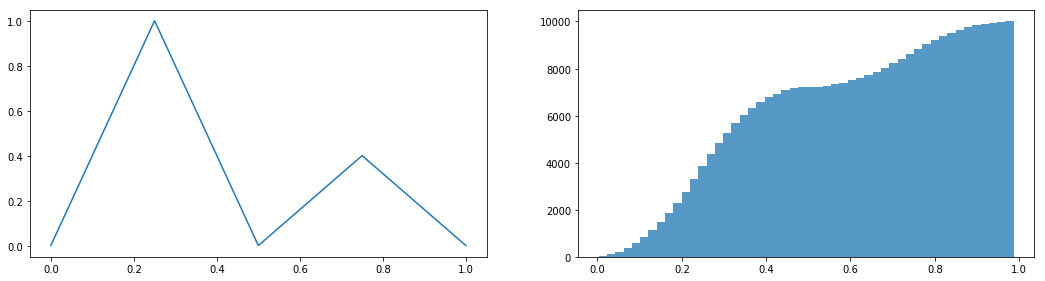

In [9]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221)
ax1.plot(x, i(x))
picks = generateDistribution(i, 10000)
ax2 = fig.add_subplot(222)
ax2.hist(picks, bins=50, alpha=0.75, cumulative=True)
plt.show()

Then by means of integrals we can calculate what the percentage is of the first large increase.

In [10]:
from scipy.integrate import quad
def percentageIncrease(function, start=0, end=1):
    totalSurface = quad(function, 0., 1.)[0]
    periodSurface = quad(function, start, end)[0]
    return periodSurface / totalSurface

In [11]:
print(percentageIncrease(i))
print(percentageIncrease(i, 0, .5))
print(percentageIncrease(i, .5, 1))

1.0
0.714285714286
0.285714285714


So the first increase in the trend is accountible for about 71% of the data. We can verify in the plot that is just about the case.

### 1.4 Add Random Noise

Generally, trends do not follow straight lines. To account for this, some random jitter should be added, as illustrated below.

In [77]:
def noise(x, c=1):
    n = np.random.randint(4, 6)
    r = [np.random.randint(20, 80) for _ in range(n*2)]
    jitter = 0
    for i in range(n):
        jitter += np.sin(r[i]*x) / float(r[i+1])
    return c * jitter

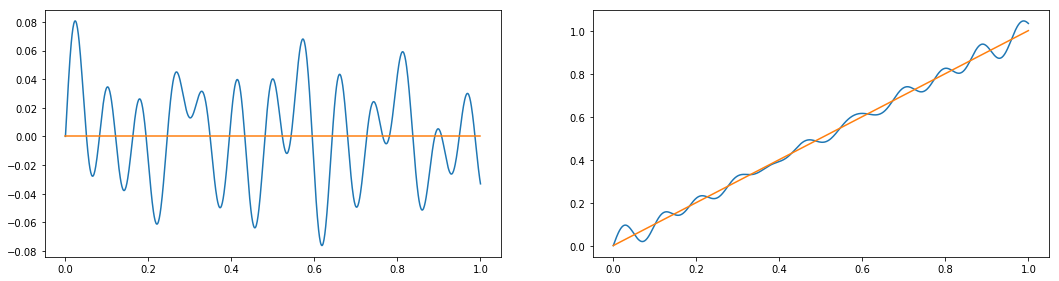

In [81]:
x = np.linspace(0,1, num=1001)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(x, noise(x), x, np.zeros(len(x)))
ax2.plot(x, x+noise(x), x, x)
plt.show()

# 2. Car Loan Data Generation - Entities
The goal is now to apply these building stones on the car loan use case. A configuration of Lily contains scripts to generate the data, and will now contain some of the code above. Below, the data is loaded to verify its trends, and to tweak the scripts if necessary.

In [14]:
path = '/Users/desiredewaele/git/lily-demo/financial/schemas/src/main/resources/scripts/.data/EntityDataAll.csv'
path = '/Users/desiredewaele/Desktop/EntityDataAll.csv'
headers = ['ID', 'PRODUCT','WAARDE', 'START', 'END', 'TYPE', 'SUBTYPE', 'ACTIF', 'MARGIN', 'RATE', 'CREDIT']
productData = pd.read_csv(path, sep=';', index_col=0, names=headers)

In [15]:
productData.loc[:,'START'] = productData.START.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
productData.loc[:,'END'] = productData.END.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
print(len(productData))
productData.head()

229870


,ID,PRODUCT,WAARDE,START,END,TYPE,SUBTYPE,ACTIF,MARGIN,RATE,CREDIT
1000001001,1,Checking Account,5039.308208,2016-06-29,2026-06-27,Checking Account,NaN,True,NaN,NaN,NaN
2000001001,1,Credit Card,NaN,2016-06-25,2026-06-23,Credit Card,NaN,True,NaN,NaN,NaN
4000001001,1,Savings Account,644524.388968,2013-05-12,2023-05-10,Savings Account,NaN,True,NaN,NaN,NaN
5000001001,1,Mutual Funds,8669.155233,2016-09-07,2026-09-05,Mutual Funds,NaN,True,NaN,NaN,NaN
6000001001,1,Bond Products,14181.429068,2012-11-19,2022-11-17,Bond Products,NaN,True,NaN,NaN,NaN


Here, some records are shown for illustration.

In [16]:
activeCarLoans = productData[productData.PRODUCT == 'Car Loan']
print(len(activeCarLoans))
activeCarLoans.head()

11645


,ID,PRODUCT,WAARDE,START,END,TYPE,SUBTYPE,ACTIF,MARGIN,RATE,CREDIT
15000002001,2,Car Loan,34850.531845,2016-09-03,2019-11-15,Car Loan,NaN,True,2.917725,4.530523,30118.205632
15000006001,6,Car Loan,32106.872614,2013-03-18,2019-09-07,Car Loan,NaN,True,3.000000,4.898624,27026.826076
15000011001,11,Car Loan,34573.142847,2016-06-23,2018-11-24,Car Loan,NaN,True,2.774340,4.306520,29862.827763
15000016001,16,Car Loan,35012.475273,2016-05-05,2020-04-07,Car Loan,NaN,True,2.592624,4.026173,28975.902215
15000020001,20,Car Loan,29431.480694,2010-05-21,2021-05-06,Car Loan,NaN,True,3.637136,5.505036,24926.316325


## 2.1 Widget 1: Car Loans & Savings Accounts Share of Wallet

In [17]:
activeCarLoans = productData[productData.PRODUCT == 'Car Loan']
activeAccounts = productData[productData.PRODUCT == 'Savings Account']
activeCustomers = productData[productData.groupby(['ID'])['START'].transform(min) == productData['START']]

In [18]:
carLoansInTime = createBins(activeCarLoans, databins)
accountsInTime = createBins(activeAccounts, databins)
activesInTime = createBins(activeCustomers, databins)

In [19]:
carLoansShare = carLoansInTime / activesInTime
accountsShare = accountsInTime / activesInTime

The plots below show the car loans, savings accounts and active customers over time (left) and the share of car loans and savings accounts (right).

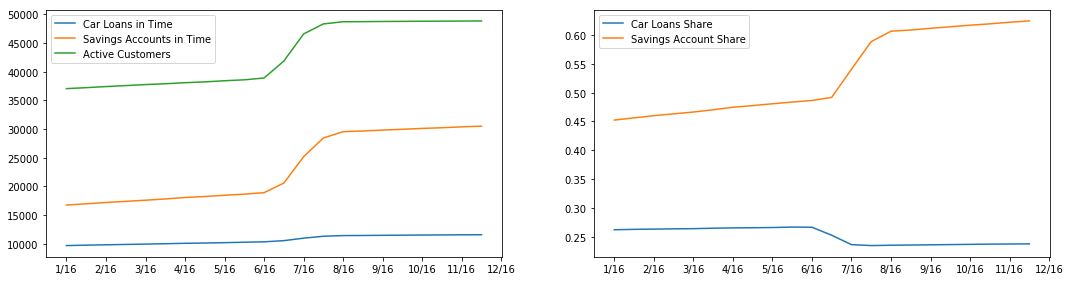

In [20]:
x = np.arange(len(databins)-1)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, carLoansInTime, label='Car Loans in Time')
ax1.plot(x, accountsInTime, label='Savings Accounts in Time')
ax1.plot(x, activesInTime, label='Active Customers')
ax2.plot(x, carLoansShare, label='Car Loans Share')
ax2.plot(x, accountsShare, label='Savings Account Share')
ax1.set_xticks(np.arange(0,len(databins),2)); ax1.set_xticklabels(ticks)
ax2.set_xticks(np.arange(0,len(databins),2)); ax2.set_xticklabels(ticks)
ax1.legend(); ax2.legend()
plt.show()

These are the percentage checks.

In [21]:
print 'Increase of total active customers in 2016. Should be 30%:', activesInTime[-1] / float(activesInTime[0])-1
print 'Car Loans Share of Wallets pre 2016. Should be 30%:', carLoansInTime[0] / float(activesInTime[0])
print 'Car Loans Share of Wallets post 2016. Should be 25%:', carLoansInTime[-1] / float(activesInTime[-1])
print 'Savings Accounts Share of Wallets pre 2016. Should be 50%:', accountsInTime[0] / float(activesInTime[0])
print 'Savings Accounts Share of Wallets post 2016. Should be 61%:', accountsInTime[-1] / float(activesInTime[-1])

Increase of total active customers in 2016. Should be 30%: 0.31842836711
Car Loans Share of Wallets pre 2016. Should be 30%: 0.261812882856
Car Loans Share of Wallets post 2016. Should be 25%: 0.237263851649
Savings Accounts Share of Wallets pre 2016. Should be 50%: 0.45235717948
Savings Accounts Share of Wallets post 2016. Should be 61%: 0.624598317539


## 2.2 Widget 2: Evolution of Rate and Margin
The left plot shows the function used to generate data from, the right plot visualizes the actual data over time.

In [351]:
# FUNCTIONS
xPoints = (np.array([-6*365, -5*365, 0, 365]) + 6*365) / (7*365.)
yPoints1 = np.array([5.5, 5.5, 4, 4.5])
yPoints2 = np.array([3.5, 3.5, 2.5, 3])
rate = interp1d(xPoints, yPoints1)
margin = interp1d(xPoints, yPoints2)

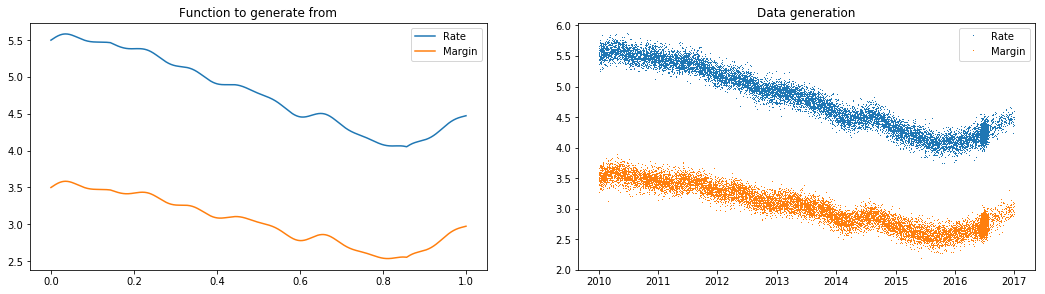

In [352]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, rate(x) + noise(x), label='Rate'); ax1.plot(x, margin(x) + noise(x), label='Margin')
ax2.plot(activeCarLoans.START, activeCarLoans.RATE, ',', label='Rate')
ax2.plot(activeCarLoans.START, activeCarLoans.MARGIN, ',', label='Margin')
ax1.legend(); ax2.legend()
ax1.set_title('Function to generate from')
ax2.set_title('Data generation')
plt.show()

## 2.3 Widget 3: Evolution of Value and Credit

The left plot shows the function used to generate data from, the right plot visualizes the actual data over time.

In [368]:
# FUNCTIONS
xPoints = (np.array([-6*365, -5*365, 365]) + 6*365) / (7*365.)
yPoints1 = np.array([30000, 30000, 35000])
yPoints2 = np.array([25000, 25000, 30000])
value = interp1d(xPoints, yPoints1)
credit = interp1d(xPoints, yPoints2)

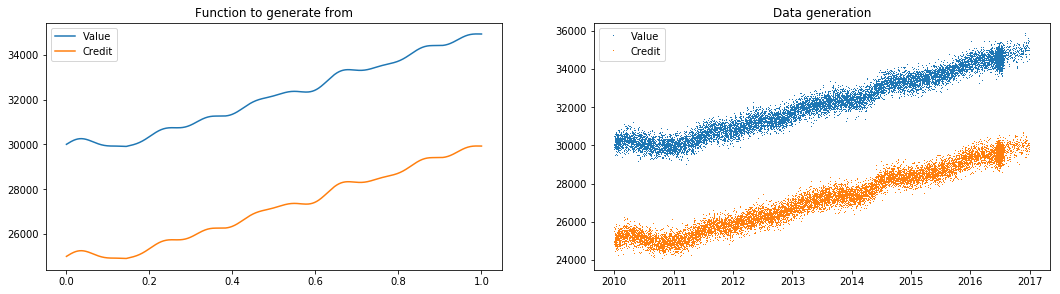

In [369]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, value(x) + noise(x, 3000), label='Value'); ax1.plot(x, credit(x) + noise(x, 3000), label='Credit')
ax2.plot(activeCarLoans.START, activeCarLoans.WAARDE, ',', label='Value')
ax2.plot(activeCarLoans.START, activeCarLoans.CREDIT, ',', label='Credit')
ax1.legend(); ax2.legend()
ax1.set_title('Function to generate from')
ax2.set_title('Data generation')
plt.show()

## 2.4 Widget 4: Age Buckets of Car Loans

The pie chart below shows the remaining car loan durations. 

In [26]:
def endDate():
    years = np.random.choice(np.arange(7), p=np.array([23, 25, 17, 12, 13, 6, 4]) / 100.)
    return (years + np.random.uniform()) * 365
picks = np.array([endDate() for _ in range(50000)])

In [27]:
carLoansInFuture = createBins(activeCarLoans, databinsF, cumulative=False)
print carLoansInFuture

[2642 2932 2004 1317 1558  718  445]


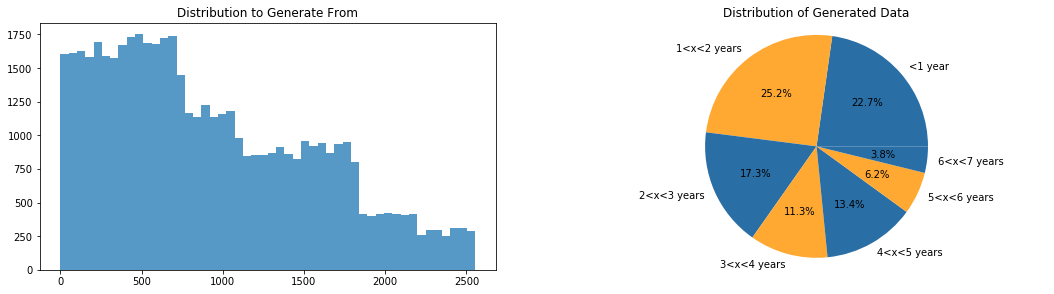

In [28]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.hist(picks, bins=50, alpha=0.75, cumulative=False)
ax1.set_title('Distribution to Generate From')

labels = '<1 year', '1<x<2 years', '2<x<3 years', '3<x<4 years', '4<x<5 years', '5<x<6 years', '6<x<7 years'
ax2.pie(carLoansInFuture, labels=labels, colors=('#2A6EA6', '#FFA933'), autopct='%1.1f%%')
ax2.axis('equal'); ax2.set_title('Distribution of Generated Data')
plt.show()

# 3. Car Loan Data Generation - Interactions

Below, some of the interactions (approved car loans) are shown for illustration.

## 3.1 Approval Interactions

In [297]:
basepath = '/Users/desiredewaele/git/lily-demo/financial/schemas/src/main/resources/scripts/.data/'
itxfile = 'CarLoans.csv'
names = pd.read_csv(basepath+'CarLoans.hdr', sep=';')
itxData = pd.read_csv(basepath+itxfile, sep=';', names=names)
itxData.loc[:,'date'] = itxData.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
itxData.loc[:,'time'] = itxData.time.apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f').time())
itxData['dayOfYear'] = itxData.date.map(lambda x: int(x.strftime('%j')) - 1)

In [298]:
print(len(itxData))
itxData.head(10)

11645


,id,date,time,sinceEpoch,goal,subgoal,channel,dayOfYear
0,2,2016-08-23,18:43:09.909821,1471970589,,,Branch,235
1,6,2013-02-12,19:38:55.983282,1360694335,,,Branch,42
2,11,2016-05-21,20:33:19.652290,1463855599,,,Branch,141
3,16,2016-04-08,20:18:16.533062,1460139496,,,Call Center,98
4,20,2010-03-30,16:37:02.563979,1269959822,,,Branch,88
5,21,2016-07-05,17:17:26.250800,1467731846,,,Branch,186
6,24,2010-02-20,16:06:51.928679,1266678411,,,Branch,50
7,27,2013-07-17,18:19:34.576111,1374077974,,,Call Center,197
8,29,2012-02-02,21:21:27.018306,1328214087,,,Call Center,32
9,31,2013-11-09,22:40:38.436904,1384033238,,,Branch,312


The plots below show the number of days of an application before the approval of the car loan (left), and the time of the application (right).

In [299]:
def daysBeforeApproval(x):
    gauss1 = gauss(x, position = 0.5, deviation = 0.250, height = 0, altitude = 1)
    gauss2 = gauss(x, position = 0.2, deviation = 0.075, height = 0, altitude = 0.25)
    return gauss1 + gauss2

In [300]:
def timestamp(x):
    return gauss(x, position = 20 / 24., deviation = 0.125, height = 0, altitude = 1)

In [301]:
days = (activeCarLoans.START.values - itxData.date.values)
days = days.astype('timedelta64[D]')
days = np.array([d.astype(int) for d in days])
hours = itxData.time.values

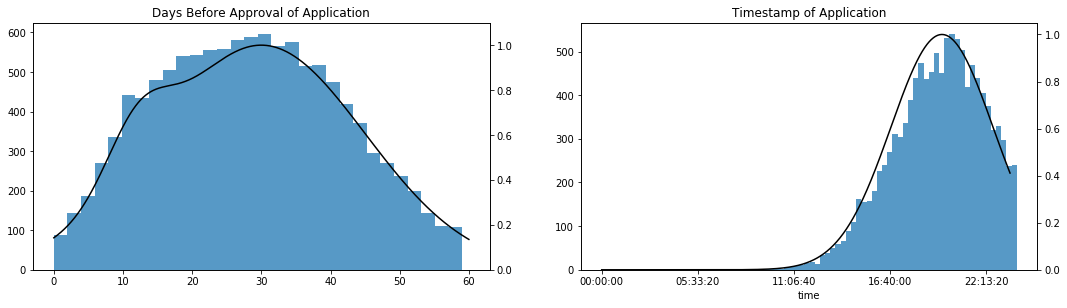

In [304]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = ax1.twinx()
ax3 = fig.add_subplot(222); ax4 = ax3.twinx()

ax1.hist(days, bins=30, alpha=0.75); ax3.hist(hours, bins=50, alpha=0.75)
ax2.plot(x*60, daysBeforeApproval(x), '-k'); ax4.plot(x*85000, timestamp(x), '-k')

ax1.set_title('Days Before Approval of Application'); ax3.set_title('Timestamp of Application')
ax2.set_ylim(0,1.1); ax4.set_ylim(0,)
plt.show()

In [305]:
print timedelta(days = int(-generateDistribution(f) * 60))
print timedelta(hours = generateDistribution(g) * 24)

-17 days, 0:00:00
2:57:40.688621


The plots below show the functions to generate the channels from, and the actual generated data. Because the numbers are relatively low, the data does not follow the functions too well on first sight.

In [306]:
def channelFunction(x):
    return [logit(x, 0.5, -200, 0.70, -0.10),
            logit(x, 0.5, -200, 0.25, 0.05),
            logit(x, 0.5, -200, 0.05, 0.05)]

In [307]:
def channelValues(channel):
    l = []
    for month in range(1, 13):
        monthlyData = itxData[itxData.date.map(lambda x: x.month == month and x.year == 2016)]
        l.append(sum(monthlyData.channel==channel) / float(len(monthlyData)))
    return l

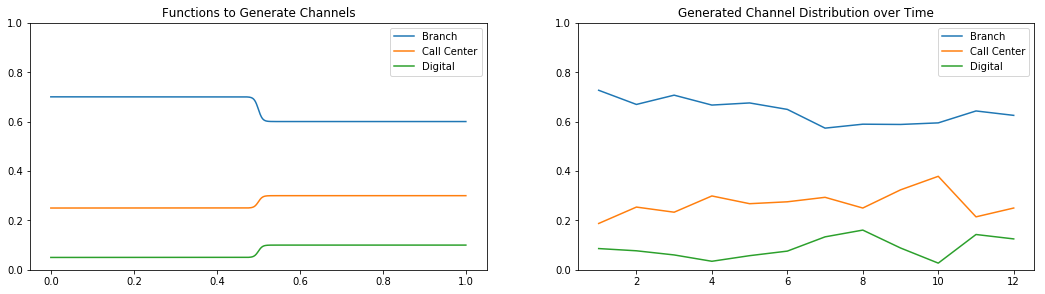

In [308]:
channels = ['Branch', 'Call Center', 'Digital']
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax1.set_ylim(0,1)
ax2 = fig.add_subplot(222); ax2.set_ylim(0,1)
xPoints1 = np.linspace(0, 1, num=1000)
xPoints2 = np.arange(1, 13, dtype=float)
for i, c in enumerate(channels):
    ax1.plot(xPoints1, channelFunction(xPoints1)[i], label=c)
    ax2.plot(xPoints2, channelValues(c), label=c)
ax1.set_title('Functions to Generate Channels')
ax2.set_title('Generated Channel Distribution over Time')
ax1.legend(); ax2.legend(); plt.show()

However, if we take the mean of channel values in the first five months and the last five months, we can see in the pie charts below that the percentages approach the numbers asked for.

In [309]:
pre = [np.mean(channelValues('Branch')[:5]),
       np.mean(channelValues('Call Center')[:5]),
       np.mean(channelValues('Digital')[:5])]
post = [np.mean(channelValues('Branch')[7:]), 
        np.mean(channelValues('Call Center')[7:]),
        np.mean(channelValues('Digital')[7:])]

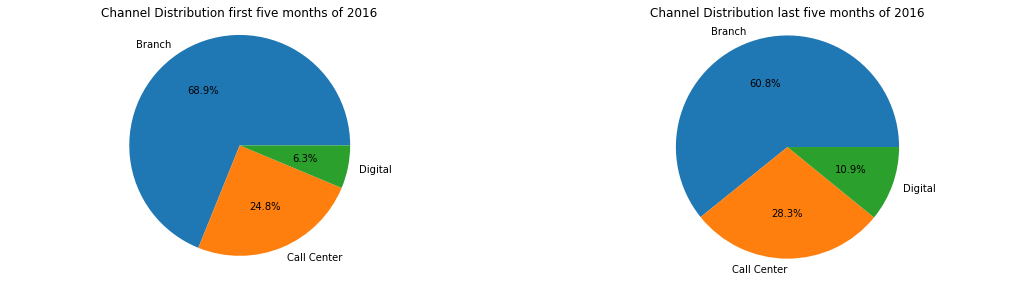

In [310]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.pie(pre, labels=channels, autopct='%1.1f%%')
ax2.pie(post, labels=channels, autopct='%1.1f%%')
ax1.set_title('Channel Distribution first five months of 2016')
ax2.set_title('Channel Distribution last five months of 2016')
ax2.axis('equal'); ax1.axis('equal')
plt.show()

In [311]:
generations = []
time = np.linspace(0, 1, num=10000)
for i, x in enumerate(time):
    generations.append(np.random.choice(channels, p=channelFunction(i)))

In [312]:
np.array(generations)

array(['Branch', 'Branch', 'Branch', ..., 'Digital', 'Digital', 'Branch'], 
      dtype='|S11')

## 3.2 Digital Interactions - Page Visits & Simulations

Below, some of the digital interactions are shown for illustration.

In [313]:
def striptime(x):
    try:
        x = datetime.strptime(x, '%H:%M:%S.%f').time()
    except:
        x = datetime.strptime(x, '%H:%M:%S').time()
    return x

In [314]:
digitalsfile = 'Digitals.csv'
names = pd.read_csv(basepath+'Digitals.hdr', sep=';')
digitals = pd.read_csv(basepath+digitalsfile, sep=';', names=names)
digitals.loc[:,'date'] = digitals.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
digitals.loc[:,'time'] = digitals.time.apply(lambda x: striptime(x))

In [315]:
print(len(digitals))
digitals.head(10)

243610


,id,date,time,sinceEpoch,goal,reason
0,2,2016-08-02,13:28:07.350476,1470137287,Page Visit,-21
1,2,2016-08-02,14:46:10.229817,1470141970,Page Visit,-21
2,2,2016-08-02,15:37:59.071575,1470145079,Page Visit,-21
3,2,2016-08-02,16:54:35.825028,1470149675,Page Visit,-21
4,2,2016-08-02,21:49:24.898855,1470167364,Page Visit,-21
5,2,2016-08-18,12:47:57.998083,1471517277,Page Visit,-5
6,2,2016-08-18,13:28:27.818117,1471519707,Page Visit,-5
7,2,2016-08-18,12:04:16.334381,1471514656,Page Visit,-5
8,2,2016-08-18,19:00:25.701289,1471539625,Page Visit,-5
9,2,2016-08-18,14:59:52.803338,1471525192,Page Visit,-5


The plots below show the number of days of a digital interaction before the application of the car loan (left), and the time of the interaction (right).

In [316]:
def daysBeforePurchase(x):
    return gauss(x, position = .5, deviation = 1, height = 0, altitude = 1)

In [317]:
def timestamp(x):
    gauss1 = gauss(x, position = 1 / 3., deviation = 0.05, height = 0, altitude = 1)
    gauss2 = gauss(x, position = 0.5, deviation = 0.25, height = 0, altitude = 1.1)
    return (gauss1 + gauss2) / 1.9

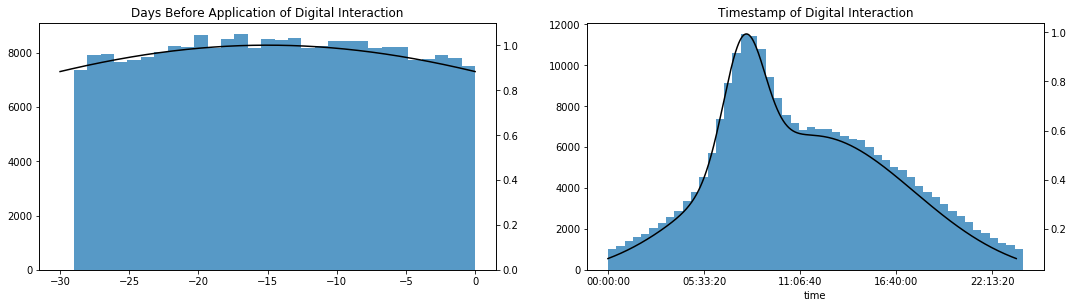

In [318]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = ax1.twinx()
ax3 = fig.add_subplot(222); ax4 = ax3.twinx()

ax1.hist(digitals.reason, bins=30, alpha=0.75)
ax3.hist(digitals.time.values, bins=50, alpha=0.75)
ax2.plot(x*-30, daysBeforePurchase(x), '-k')
ax4.plot(x*85000, timestamp(x), '-k')

ax1.set_title('Days Before Application of Digital Interaction')
ax3.set_title('Timestamp of Digital Interaction')
ax2.set_ylim(0,1.1)
plt.show()

The plot below shows the functions to generate the number of digital interactions per customer (left) and the actual generated number of digital interactions per customer.

In [319]:
def numberOfPageVisits(x):
    return logit(x, position=0.65, spread=-20, setoff=10, altitude=15)

def numberOfSimulations(x):
    return logit(x, position=0.65, spread=-20, setoff=5, altitude=5)

def numberOfNonCarLoaners(x):
    return logit(x, position=0.65, spread=-20, setoff=85, altitude=180)

def numberOfTotalDigitals(x):
    return numberOfPageVisits(x) + numberOfSimulations(x) + numberOfNonCarLoaners(x)

In [320]:
numberOfItx = pd.DataFrame(digitals[digitals.goal=='Page Visit'].groupby(['id']).size(), columns=['itx'])
numberOfSim = pd.DataFrame(digitals[digitals.goal=='Simulation'].groupby(['id']).size(), columns=['sim'])
itxData = pd.merge(itxData, numberOfItx, left_on='id', right_index=True, how='left')
itxData = pd.merge(itxData, numberOfSim, left_on='id', right_index=True, how='left')

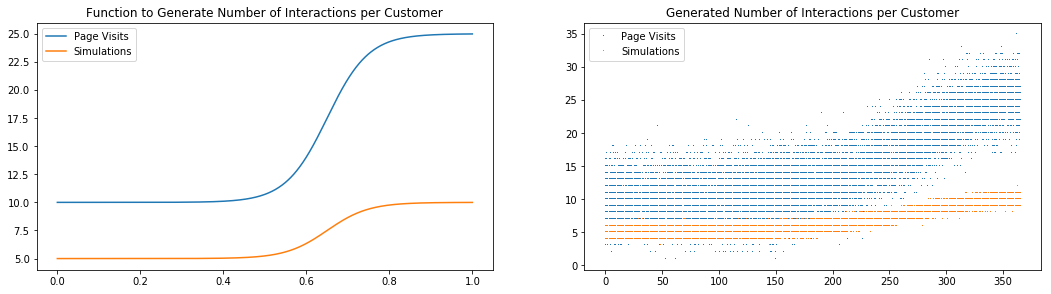

In [321]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, numberOfPageVisits(x), label = 'Page Visits')
ax1.plot(x, numberOfSimulations(x), label = 'Simulations')
ax2.plot(itxData.dayOfYear, itxData.itx, ',', label='Page Visits')
ax2.plot(itxData.dayOfYear, itxData.sim, ',', label='Simulations')
ax1.set_title('Function to Generate Number of Interactions per Customer')
ax2.set_title('Generated Number of Interactions per Customer')
ax1.legend(); ax2.legend()
plt.show()

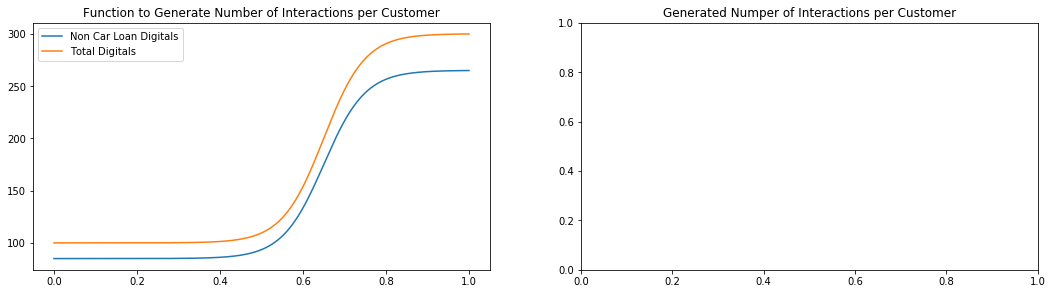

In [322]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, numberOfNonCarLoaners(x), label = 'Non Car Loan Digitals')
ax1.plot(x, numberOfTotalDigitals(x), label = 'Total Digitals ')
#ax2.plot(itxData.dayOfYear, itxData.itx, ',', label='Page Visits')
#ax2.plot(itxData.dayOfYear, itxData.sim, ',', label='Simulations')
ax1.set_title('Function to Generate Number of Interactions per Customer')
ax2.set_title('Generated Numper of Interactions per Customer')
ax1.legend(); ax2.legend()
plt.show()

## 3.3 Channel Branch

Below, some of the branch interactions are shown for illustration.

In [52]:
branchfile = 'Branches.csv'
names = pd.read_csv(basepath+'Branches.hdr', sep=';')
branches = pd.read_csv(basepath+branchfile, sep=';', names=names)
branches.loc[:,'date'] = branches.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
branches.loc[:,'time'] = branches.time.apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f').time())

In [53]:
print(len(branches))
branches.head()

9131


,id,date,time,sinceEpoch,goal,reason
0,2,2016-08-01,08:15:57.626219,1470032157,NaN,-22
1,6,2013-02-12,12:39:13.715425,1360669153,NaN,-12
2,11,2016-05-30,04:17:23.116151,1464574643,NaN,-15
3,16,2016-03-23,07:51:35.990459,1458715895,NaN,-16
4,20,2010-05-03,17:02:47.387669,1272898967,NaN,-10


The plots below show the number of days of a branch interaction before the application of the car loan (left), and the time of the interaction (right).

In [54]:
def daysBeforePurchase(x):
    return gauss(x, position = 0, deviation = .85, height = -.5, altitude = 2)

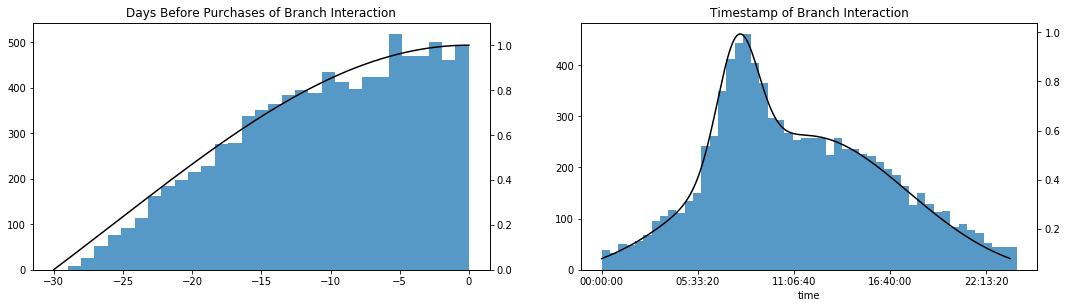

In [55]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = ax1.twinx()
ax3 = fig.add_subplot(222); ax4 = ax3.twinx()

ax1.hist(branches.reason, bins=30, alpha=0.75)
ax3.hist(branches.time.values, bins=50, alpha=0.75)
ax2.plot(x*-30, daysBeforePurchase(x), '-k')
ax4.plot(x*85000, timestamp(x), '-k')

ax1.set_title('Days Before Purchases of Branch Interaction')
ax3.set_title('Timestamp of Branch Interaction')
ax2.set_ylim(0,1.1)
plt.show()

The plot below shows the functions to generate the number of branch interactions per customer (left) and the actual generated number of branch interactions per customer.

In [56]:
def numberOfBranches(x):
    return logit(x, position=0.5, spread=100, setoff=.5, altitude=.5)

In [57]:
numberOfBra = pd.DataFrame(branches.groupby(['id']).size(), columns=['bra'])
itxData = pd.merge(itxData, numberOfBra, left_on='id', right_index=True, how='left')
itxData.bra = itxData.bra.apply(lambda x: 0 if np.isnan(x) else x)

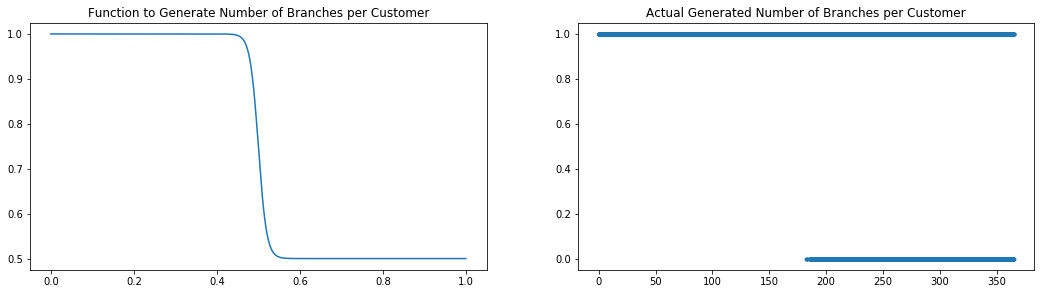

In [58]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, numberOfBranches(x)); ax2.plot(itxData.dayOfYear, itxData.bra, '.')
ax1.set_title('Function to Generate Number of Branches per Customer')
ax2.set_title('Actual Generated Number of Branches per Customer')
plt.show()

## 3.4 Channel Call Center

Below, some of the call center interactions are shown for illustration.

In [59]:
callcenterfile = 'callcenter.csv'
names = pd.read_csv(basepath+'callcenter.hdr', sep=';')
callcenters = pd.read_csv(basepath+callcenterfile, sep=';', names=names)
callcenters.loc[:,'date'] = callcenters.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
callcenters.loc[:,'time'] = callcenters.time.apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f').time())

In [60]:
print(len(callcenters))
callcenters.head()

5227


,id,date,time,sinceEpoch,goal,reason
0,2,2016-08-20,17:41:24.273055,1471707684,NaN,-3
1,31,2013-11-07,13:55:42.502074,1383828942,NaN,-19
2,48,2015-10-18,20:58:44.241499,1445194724,NaN,-19
3,62,2011-07-06,20:07:31.309853,1309975651,NaN,-22
4,63,2014-07-11,07:33:40.619045,1405056820,NaN,-21


The plots below show the number of days of a call center interaction before the application of the car loan (left), and the time of the interaction (right).

In [61]:
def daysBeforePurchase(x):
    return gauss(x, position = 1/3., deviation = .56, height = -.5, altitude = 2)

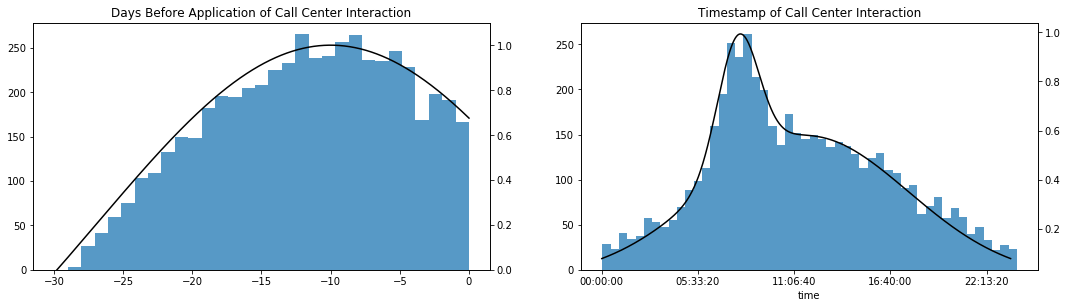

In [62]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = ax1.twinx()
ax3 = fig.add_subplot(222); ax4 = ax3.twinx()

ax1.hist(callcenters.reason, bins=30, alpha=0.75)
ax3.hist(callcenters.time.values, bins=50, alpha=0.75)
ax2.plot(x*-30, daysBeforePurchase(x), '-k')
ax4.plot(x*85000, timestamp(x), '-k')

ax1.set_title('Days Before Application of Call Center Interaction')
ax3.set_title('Timestamp of Call Center Interaction')
ax2.set_ylim(0,1.1)
plt.show()

The plot below shows the functions to generate the number of call center interactions per customer (left) and the actual generated number of call center interactions per customer.

In [63]:
def numberOfCallCenters(x):
    return logit(x, position=0.5, spread=-100, setoff=.25, altitude=.5)

In [64]:
numberOfCal = pd.DataFrame(callcenters.groupby(['id']).size(), columns=['cal'])
itxData = pd.merge(itxData, numberOfCal, left_on='id', right_index=True, how='left')
itxData.cal = itxData.cal.apply(lambda x: 0 if np.isnan(x) else x)

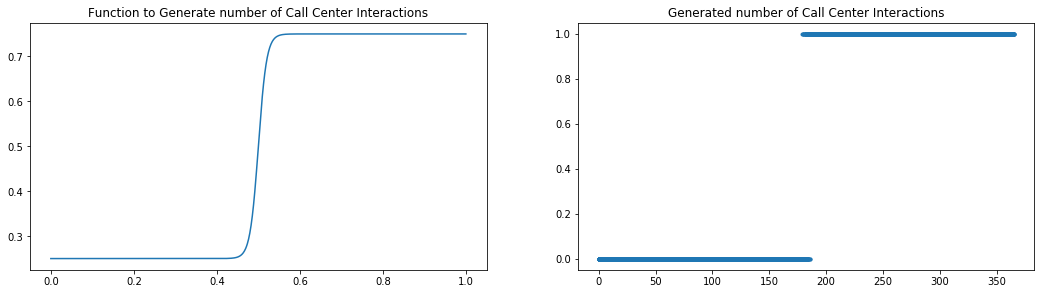

In [65]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, numberOfCallCenters(x)); ax2.plot(itxData.dayOfYear, itxData.cal, '.')
ax1.set_title('Function to Generate number of Call Center Interactions')
ax2.set_title('Generated number of Call Center Interactions')
plt.show()

Percentage Checks.

In [66]:
pre2016 = itxData[itxData.dayOfYear < 150]
post2016 = itxData[itxData.dayOfYear > 180]

In [67]:
print 'Should be 10 and 25:', pre2016.itx.mean(), post2016.itx.mean()
print 'Should be 2 and 4:', pre2016.sim.mean(), post2016.sim.mean()
print 'Should be 1 and 0.5:', pre2016.bra.mean(), post2016.bra.mean()
print 'Should be 0.25 and 0.75', pre2016.cal.mean(), post2016.cal.mean()

Should be 10 and 25: 10.0001988862 24.6761202496
Should be 2 and 4: 2.00776583035 3.94290035924
Should be 1 and 0.5: 1.0 0.52467385139
Should be 0.25 and 0.75 0.0 0.98771034222


## 3.5 Refusals and Complaints

Below, some of the refusal & complaint interactions are shown for illustration.

In [68]:
basepath = '/Users/desiredewaele/git/lily-demo/financial/schemas/src/main/resources/scripts/.data/'
rejectionsFile = 'rejections.csv'; complaintsFile = 'complaints.csv'
names1 = pd.read_csv(basepath+'rejections.hdr', sep=';')
names2 = pd.read_csv(basepath+'complaints.hdr', sep=';')
rejectedCarLoans = pd.read_csv(basepath+rejectionsFile, sep=';', names=names)
complaintsCarLoans = pd.read_csv(basepath+complaintsFile, sep=';', names=names)
rejectedCarLoans.loc[:,'date'] = rejectedCarLoans.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
complaintsCarLoans.loc[:,'date'] = complaintsCarLoans.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [69]:
print 'Number of rejections:', len(rejectedCarLoans)
rejectedCarLoans.head(10)

Number of rejections: 6104


,id,date,time,sinceEpoch,goal,reason
0,7,2016-06-16,16:19:39.593046,1466086779,Reject Purchase,False
1,32,2016-07-01,6:05:15.921856,1467345915,Reject Purchase,False
2,39,2013-02-13,7:14:16.897741,1360736056,Reject Purchase,False
3,41,2013-08-28,5:09:26.981827,1377659366,Reject Purchase,False
4,45,2015-03-16,8:22:44.549070,1426490564,Reject Purchase,False
5,54,2013-07-20,12:07:16.087355,1374314836,Reject Purchase,False
6,56,2011-06-09,4:51:51.955239,1307587911,Reject Purchase,False
7,75,2016-06-28,10:35:33.183077,1467102933,Reject Purchase,False
8,91,2016-06-15,15:50:50.234664,1465998650,Reject Purchase,False
9,99,2010-04-14,13:54:33.157138,1271246073,Reject Purchase,False


In [70]:
print 'Number of complaints:', len(complaintsCarLoans)
complaintsCarLoans.head(10)

Number of complaints: 66


,id,date,time,sinceEpoch,goal,reason
0,7,2016-06-22,2:24:29.153748,1466555069,Raise Complaint,Car Loan Rejection
1,691,2016-06-28,10:42:01.924836,1467103321,Raise Complaint,Car Loan Rejection
2,4670,2016-06-27,5:45:03.595910,1466999103,Raise Complaint,Car Loan Rejection
3,5532,2012-02-23,9:48:39.372626,1329986919,Raise Complaint,Car Loan Rejection
4,5605,2016-06-11,2:34:10.706251,1465605250,Raise Complaint,Car Loan Rejection
5,6435,2010-02-09,0:09:52.647568,1265670592,Raise Complaint,Car Loan Rejection
6,6698,2016-06-30,3:58:28.204533,1467251908,Raise Complaint,Car Loan Rejection
7,7217,2016-07-09,13:51:20.065191,1468065080,Raise Complaint,Car Loan Rejection
8,7706,2016-07-10,15:46:01.737713,1468158361,Raise Complaint,Car Loan Rejection
9,8506,2012-04-13,3:32:29.426904,1334280749,Raise Complaint,Car Loan Rejection


The plots below show the number of total, approved and rejected car loan applications (left) and the share of approved and rejected applications, with respect to the total number of applications (right).

In [71]:
approvals = createBins(activeCarLoans, databins, 'START')
rejections = createBins(rejectedCarLoans, databins, 'date')
complaints = createBins(complaintsCarLoans, databins, 'date')
applications = approvals + rejections

In [72]:
rejectionsShare = rejections / applications
approvalShare = approvals / applications
complaintsShare = complaints / applications

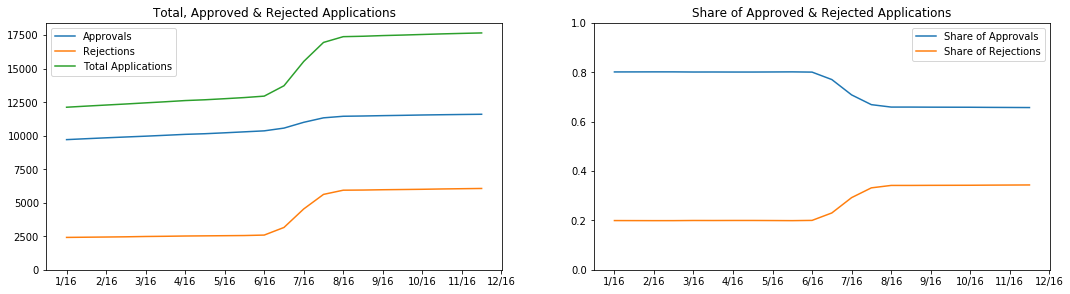

In [73]:
x = np.arange(len(databins)-1)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, approvals, label='Approvals')
ax1.plot(x, rejections, label='Rejections')
ax1.plot(x, applications, label = 'Total Applications')
ax2.plot(x, approvalShare, label='Share of Approvals')
ax2.plot(x, rejectionsShare, label='Share of Rejections')
ax1.set_title('Total, Approved & Rejected Applications')
ax2.set_title('Share of Approved & Rejected Applications')
ax1.legend(); ax2.legend(); ax1.set_ylim(0,); ax2.set_ylim(0,1)
ax1.set_xticks(np.arange(0,len(databins),2)); ax1.set_xticklabels(ticks)
ax2.set_xticks(np.arange(0,len(databins),2)); ax2.set_xticklabels(ticks)
plt.show()

In [74]:
rejectionsShare[0], rejectionsShare[-1]

(0.19924067348960053, 0.34337827121332276)

The plots below show the number of complaints (left) and the share of complaints, with respect to the total number of refusals (right).

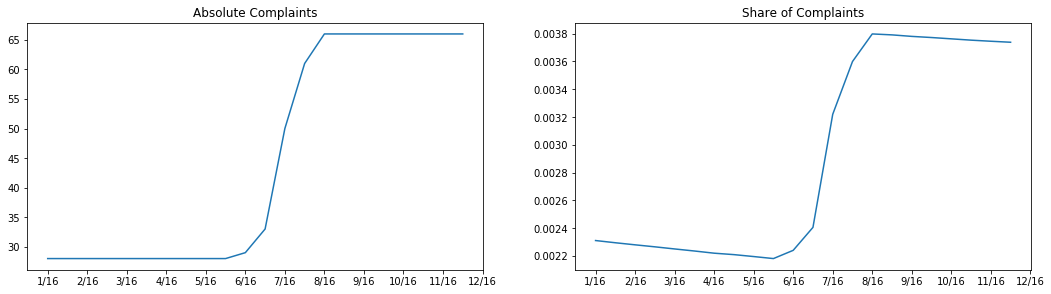

In [75]:
x = np.arange(len(databins)-1)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.plot(x, complaints); ax2.plot(x, complaintsShare)
ax1.set_title('Absolute Complaints'); ax2.set_title('Share of Complaints')
ax1.set_xticks(np.arange(0,len(databins),2)); ax1.set_xticklabels(ticks)
ax2.set_xticks(np.arange(0,len(databins),2)); ax2.set_xticklabels(ticks)
plt.show()

# 4. Data Ingest in Lily

## Data on Cluster

Csv files on cluster are identical.

## Dataframe in Lily

Print out first rows of dataframe.

In [457]:
basepath = '/Users/desiredewaele/Desktop/Car Loan Test 2016/'
names = pd.read_csv(basepath+'dataframe_columns.csv', sep='|')
data = pd.read_csv(basepath+'dataframe.csv', sep='|', names=names.name)
data.head(10)

,ID,referenceTime,filterEvaluationReferenceTime,originalSourceIds,marginCarLoans,rateCarLoans,valueCarLoans,creditCarLoans,endDateCarLoan,remainingYearsCarLoan,flagCarLoan,totalActiveCarLoans,ageBuckets_Between 1 and 2 years,ageBuckets_Between 2 and 3 years,ageBuckets_Between 3 and 4 years,ageBuckets_Between 4 and 5 years,ageBuckets_Between 5 and 6 years,ageBuckets_Between 6 and 7 years,ageBuckets_Less than 1 year,startDateFirstActiveProduct
0,4629397008703059450,2016-10-20T00:00:00.000Z,2016-10-20T00:00:00.000Z,"[""""CRM:23740""""]",NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-01-21
1,4629708226028632646,2016-10-20T00:00:00.000Z,2016-10-20T00:00:00.000Z,"[""""CRM:49458""""]",2.904410,4.233128,33453.439819,28641.530299,2020-04-15,3.0,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2002-01-07
2,4631103422335546563,2016-10-20T00:00:00.000Z,2016-10-20T00:00:00.000Z,"[""""CRM:36791""""]",3.649509,5.491374,30013.098112,25015.247933,2018-10-03,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2001-04-24
3,4631477869845456654,2016-10-20T00:00:00.000Z,2016-10-20T00:00:00.000Z,"[""""CRM:11937""""]",NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-10-29
4,4631716897349132558,2016-10-20T00:00:00.000Z,2016-10-20T00:00:00.000Z,"[""""CRM:19919""""]",NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-06-11
5,4631745313545573009,2016-10-20T00:00:00.000Z,2016-10-20T00:00:00.000Z,"[""""CRM:33493""""]",3.202134,4.836524,31471.741023,26345.509726,2021-01-27,4.0,1.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2001-10-24
6,4632271446909831584,2016-10-20T00:00:00.000Z,2016-10-20T00:00:00.000Z,"[""""CRM:40736""""]",2.790408,4.204464,34896.431530,29436.387319,2018-07-17,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2003-05-28
7,4632584950405050460,2016-10-20T00:00:00.000Z,2016-10-20T00:00:00.000Z,"[""""CRM:42075""""]",3.209445,4.914173,31354.817155,26085.970090,2018-07-02,1.0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2003-12-16
8,4633302124294204364,2016-10-20T00:00:00.000Z,2016-10-20T00:00:00.000Z,"[""""CRM:9937""""]",NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-06-08
9,4633450077679936945,2016-10-20T00:00:00.000Z,2016-10-20T00:00:00.000Z,"[""""CRM:7386""""]",NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-02-02


3 customer ids in dataframe

In [484]:
data[data.originalSourceIds.isin(['[""CRM:6""]', '[""CRM:9937""]', '[""CRM:49458""]'])]

,ID,referenceTime,filterEvaluationReferenceTime,originalSourceIds,marginCarLoans,rateCarLoans,valueCarLoans,creditCarLoans,endDateCarLoan,remainingYearsCarLoan,flagCarLoan,totalActiveCarLoans,ageBuckets_Between 1 and 2 years,ageBuckets_Between 2 and 3 years,ageBuckets_Between 3 and 4 years,ageBuckets_Between 4 and 5 years,ageBuckets_Between 5 and 6 years,ageBuckets_Between 6 and 7 years,ageBuckets_Less than 1 year,startDateFirstActiveProduct
1,4629708226028632646,2016-10-20T00:00:00.000Z,2016-10-20T00:00:00.000Z,"[""""CRM:49458""""]",2.90441,4.233128,33453.439819,28641.530299,2020-04-15,3.0,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2002-01-07
8,4633302124294204364,2016-10-20T00:00:00.000Z,2016-10-20T00:00:00.000Z,"[""""CRM:9937""""]",NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-06-08
8215,7588638892621998695,2016-10-20T00:00:00.000Z,2016-10-20T00:00:00.000Z,"[""""CRM:6""""]",3.00000,4.898624,32106.872614,27026.826076,2019-09-07,2.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2001-08-13


same 3 customerids in product table

In [486]:
productData[(productData.PRODUCT == 'Car Loan') & (productData.ID.isin([6, 9937, 49458]))]

,ID,PRODUCT,WAARDE,START,END,TYPE,SUBTYPE,ACTIF,MARGIN,RATE,CREDIT
15000006001,6,Car Loan,32106.872614,2013-03-18,2019-09-07,Car Loan,NaN,True,3.0,4.898624,27026.826076


In [474]:
len(data[-np.isnan(data.marginCarLoans)]), len(productData[(productData.PRODUCT == 'Car Loan')])

(9182, 11645)

Compare means (excluding non-nan's) with expected values according to functions above. These behave as expected.

In [413]:
timeX = 2484 / (7.*365) # Normalized day number of 2016-10-20
print 'Margin:', data.marginCarLoans.mean(), 'should be', margin(timeX) + noise(timeX)
print 'Rate:  ', data.rateCarLoans.mean(), 'should be', rate(timeX) + noise(timeX)
print 'Value: ', data.valueCarLoans.mean(), 'should be', value(timeX) + noise(timeX)
print 'Credit:', data.creditCarLoans.mean(), 'should be', credit(timeX) + noise(timeX)

Margin: 3.02033486994 should be 2.92255811681
Rate:   4.75997576329 should be 4.42255811681
Value:  32241.0469687 should be 34837.9193618
Credit: 27246.4926221 should be 29837.9193618


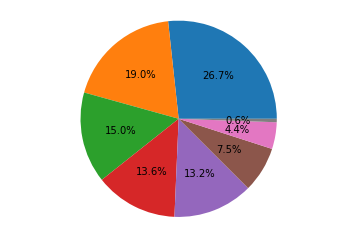

In [464]:
plt.pie(data.remainingYearsCarLoan.value_counts(), autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Compare means (including non-nan's with default value 0) with expected values according to functions above. These numbers are shown by the Lily widgets.

In [383]:
data.marginCarLoans = data.marginCarLoans.apply(lambda x: 0 if np.isnan(x) else x)
data.rateCarLoans = data.rateCarLoans.apply(lambda x: 0 if np.isnan(x) else x)
data.valueCarLoans = data.valueCarLoans.apply(lambda x: 0 if np.isnan(x) else x)
data.creditCarLoans = data.creditCarLoans.apply(lambda x: 0 if np.isnan(x) else x)

In [384]:
print 'Margin:', data.marginCarLoans.mean(), 'should be', margin(timeX) + noise(timeX)
print 'Rate:  ', data.rateCarLoans.mean(), 'should be', rate(timeX) + noise(timeX)
print 'Value: ', data.valueCarLoans.mean(), 'should be', value(timeX) + noise(timeX)
print 'Credit:', data.creditCarLoans.mean(), 'should be', credit(timeX) + noise(timeX)

Margin: 1.83391410293 should be 2.92255811681
Rate:   2.88882861977 should be 4.42255811681
Value:  19624.8011965 should be 34837.9193618
Credit: 16792.3356759 should be 29837.9193618
